In [1]:
!pip install patchify

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify
from math import log2
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] =64
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    """ Loading the images and masks """
    X = sorted(glob(os.path.join(path, "images", "*.png")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))

    """ Spliting the data into training and testing """
    split_size = int(len(X) * split)

    train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

In [8]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("files", "unetr.keras")
    csv_path = os.path.join("files", "log.csv")


In [9]:
""" Dataset """
dataset_path = "/kaggle/input/brain-tumor-segmentation"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 	1840 - 1840
Valid: 	612 - 612
Test: 	612 - 612


In [10]:
def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    z9 = L.Reshape(shape)(z9)
    z12 = L.Reshape(shape)(z12)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    ## Decoder 1
    x = deconv_block(z12, 128)

    s = deconv_block(z9, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])

    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 2
    x = deconv_block(x, 64)

    s = deconv_block(z6, 64)
    s = conv_block(s, 64)
    s = deconv_block(s, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    ## Decoder 3
    x = deconv_block(x, 32)

    s = deconv_block(z3, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)
    s = deconv_block(s, 32)
    s = conv_block(s, 32)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 32)
    x = conv_block(x, 32)

    ## Decoder 4
    x = deconv_block(x, 16)

    s = conv_block(z0, 16)
    s = conv_block(s, 16)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 16)
    x = conv_block(x, 16)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")
'''
if __name__ == "__main__":
    config = {}
    config["image_size"] = 512
    config["num_layers"] = 12
    config["hidden_dim"] = 64
    config["mlp_dim"] = 128
    config["num_heads"] = 6
    config["dropout_rate"] = 0.1
    config["patch_size"] = 1
    config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
    config["num_channels"] = 3

    model = build_unetr_2d(config)
    model.summary()

'''

'\nif __name__ == "__main__":\n    config = {}\n    config["image_size"] = 512\n    config["num_layers"] = 12\n    config["hidden_dim"] = 64\n    config["mlp_dim"] = 128\n    config["num_heads"] = 6\n    config["dropout_rate"] = 0.1\n    config["patch_size"] = 1\n    config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)\n    config["num_channels"] = 3\n\n    model = build_unetr_2d(config)\n    model.summary()\n\n'

In [11]:
""" Model """
model = build_unetr_2d(cf)
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, "accuracy"])
model.summary()

Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 768)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 128)       │         98,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 128)       │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 128)       │        395,648 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 128)       │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 128)       │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 64)        │          8,256 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 64)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256, 128)       │          8,320 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256, 128)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 128)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 128)       │            256 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 128)       │        395,648 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 128)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 6,143,089 (23.43 MB)

 Trainable params: 6,141,361 (23.43 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [12]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]

In [13]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.3676 - dice_coef: 0.0434 - loss: 0.9566
Epoch 1: val_loss improved from inf to 0.94259, saving model to files/unetr.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 123s 376ms/step - accuracy: 0.3690 - dice_coef: 0.0435 - loss: 0.9565 - val_accuracy: 0.6670 - val_dice_coef: 0.0571 - val_loss: 0.9426 - learning_rate: 1.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7421 - dice_coef: 0.0657 - loss: 0.9343
Epoch 2: val_loss improved from 0.94259 to 0.92908, saving model to files/unetr.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.7422 - dice_coef: 0.0657 - loss: 0.9343 - val_accuracy: 0.8252 - val_dice_coef: 0.0705 - val_loss: 0.9291 - learning_rate: 1.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7806 - dice_coef: 0.0719 - loss: 0.9281
Epoch 3: val_loss improved from 0.92908 to 0.92181, saving model to files/unetr.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 1

In [14]:
import pandas as pd
metrics = pd.read_csv("/kaggle/working/files/log.csv")
metrics

,epoch,accuracy,dice_coef,learning_rate,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.530683,0.049954,1.000000e-04,0.950046,0.667008,0.057136,0.942590
1,1,0.754585,0.065304,1.000000e-04,0.934696,0.825192,0.070452,0.929077
2,2,0.790918,0.071063,1.000000e-04,0.928937,0.859508,0.077667,0.921805
3,3,0.822031,0.076094,1.000000e-04,0.923906,0.789505,0.077116,0.922567
4,4,0.844880,0.081192,1.000000e-04,0.918808,0.937589,0.083210,0.916369
...,...,...,...,...,...,...,...,...
80,80,0.996995,0.900970,1.000000e-07,0.099030,0.990258,0.659535,0.333424
81,81,0.996969,0.900300,1.000000e-07,0.099700,0.990258,0.659564,0.333402
82,82,0.996992,0.900932,1.000000e-07,0.099068,0.990258,0.659580,0.333393
83,83,0.996998,0.900978,1.000000e-07,0.099022,0.990259,0.659395,0.333572


<Axes: >

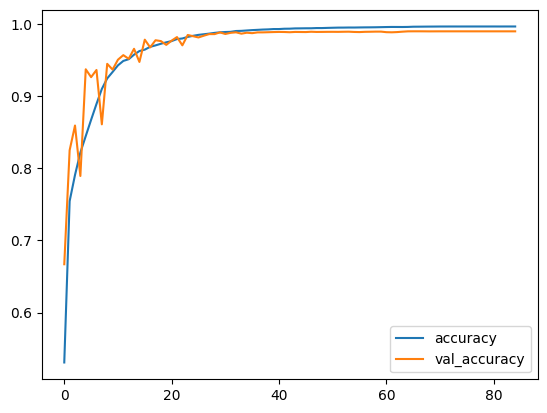

In [15]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

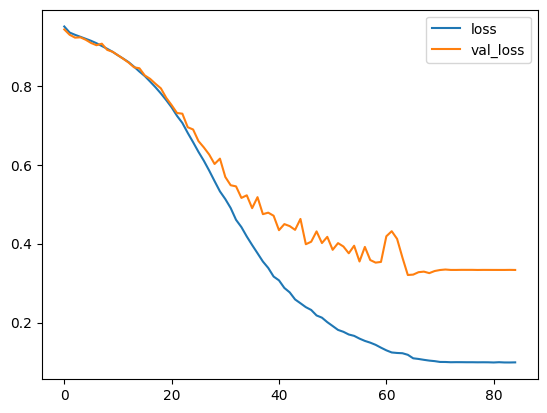

In [16]:
metrics[['loss','val_loss']].plot()

In [17]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [18]:
results = model.evaluate(test_dataset)

# Print Results
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[2]:.4f}")
print(f"Test Dice Coefficient: {results[1]*100:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.9904 - dice_coef: 0.6771 - loss: 0.3231
Test Loss: 0.3481
Test Accuracy: 0.9901
Test Dice Coefficient: 65.5975


  0%|          | 0/20 [00:00<?, ?it/s]

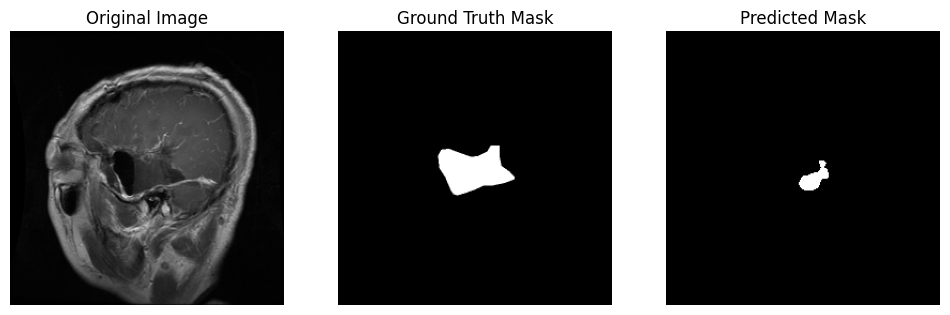

  5%|▌         | 1/20 [00:05<01:51,  5.87s/it]

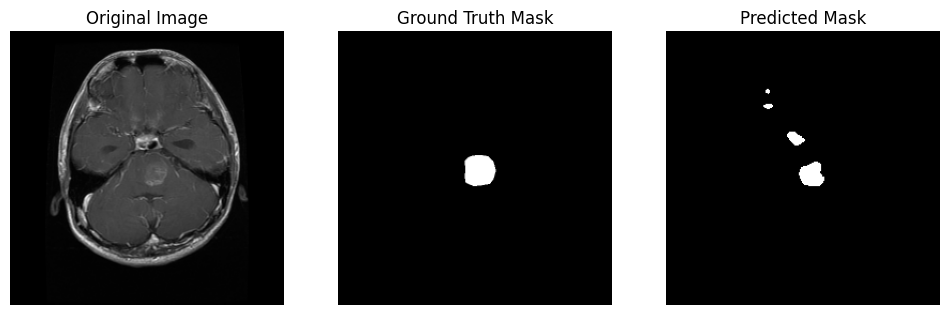

 10%|█         | 2/20 [00:06<00:47,  2.63s/it]

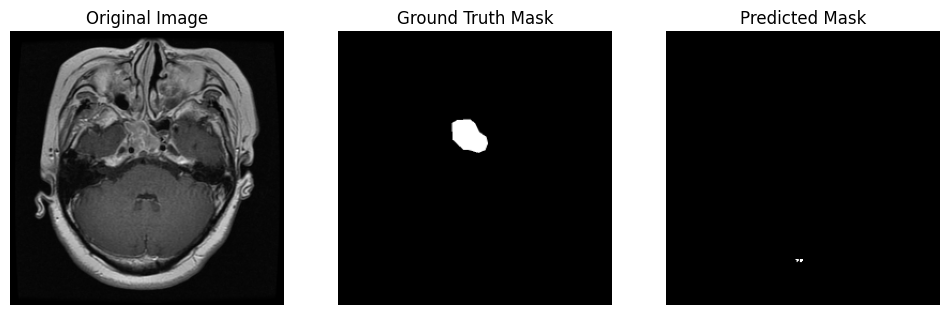

 15%|█▌        | 3/20 [00:06<00:27,  1.59s/it]

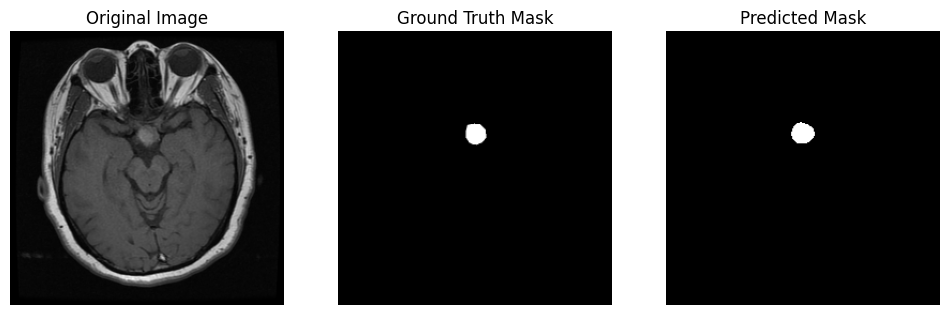

 20%|██        | 4/20 [00:06<00:17,  1.11s/it]

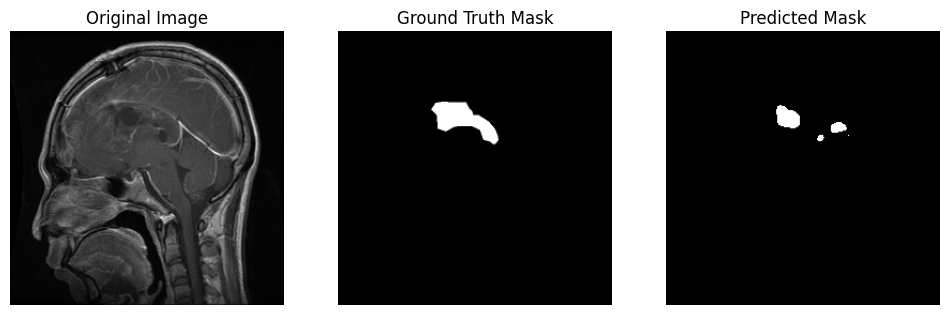

 25%|██▌       | 5/20 [00:07<00:12,  1.20it/s]

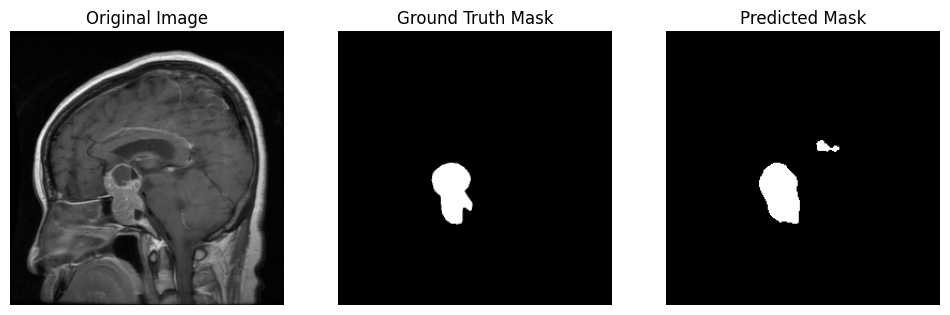

 30%|███       | 6/20 [00:07<00:09,  1.48it/s]

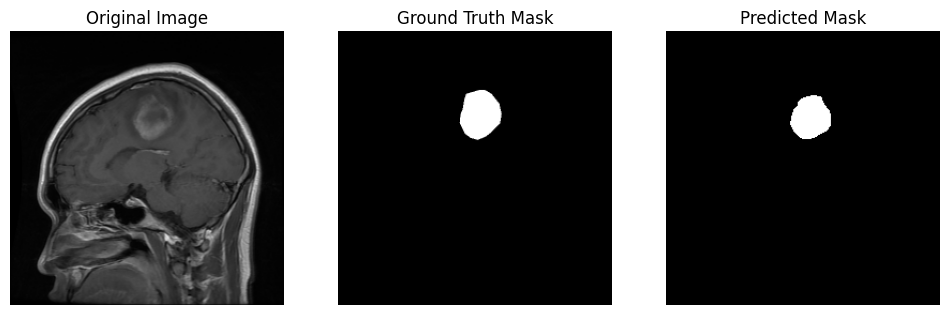

 35%|███▌      | 7/20 [00:08<00:09,  1.33it/s]

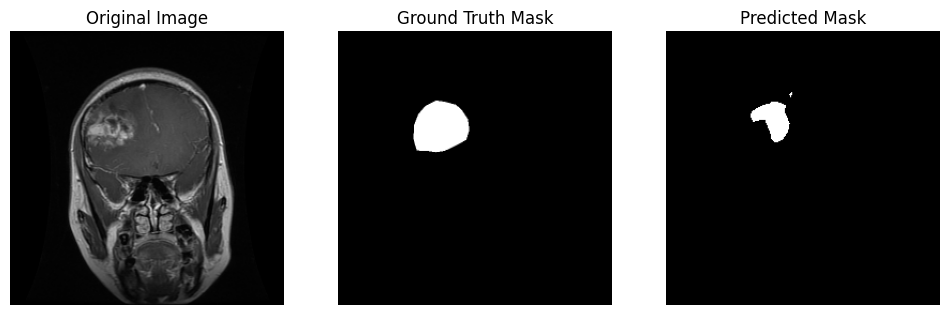

 40%|████      | 8/20 [00:08<00:07,  1.59it/s]

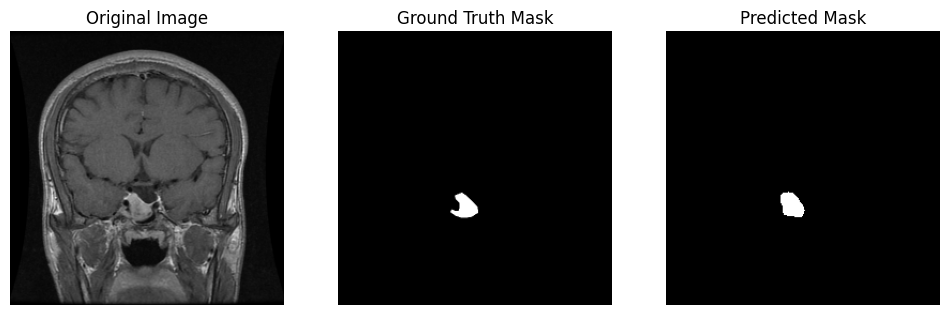

 45%|████▌     | 9/20 [00:09<00:06,  1.83it/s]

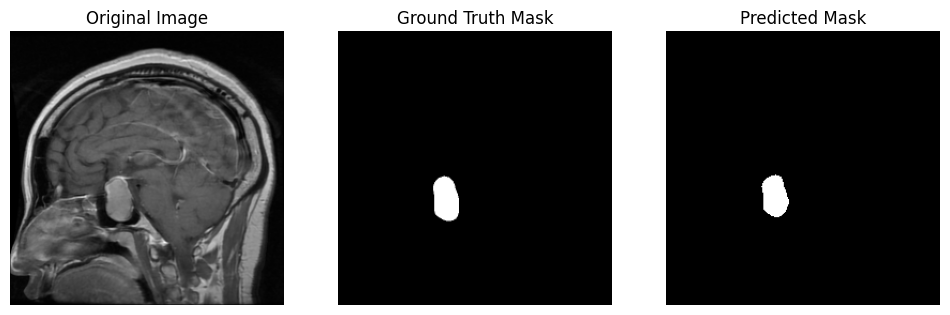

 50%|█████     | 10/20 [00:09<00:04,  2.06it/s]

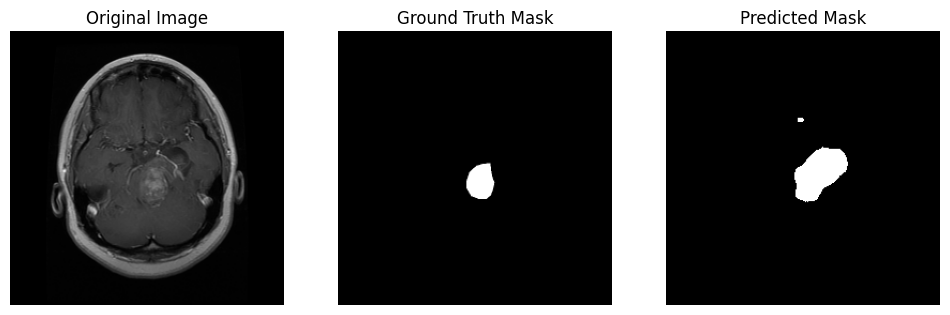

 55%|█████▌    | 11/20 [00:10<00:03,  2.26it/s]

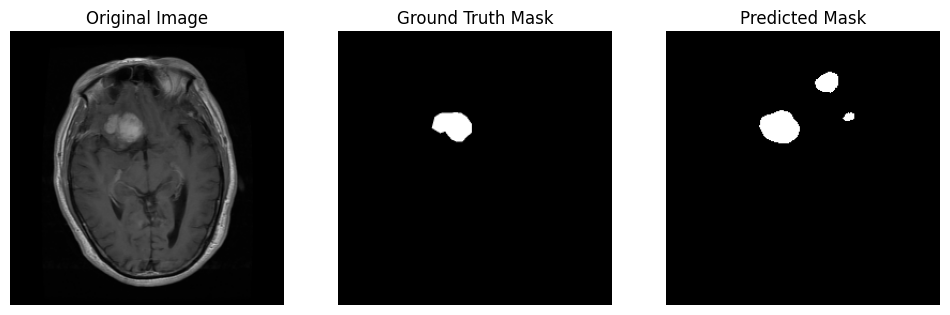

 60%|██████    | 12/20 [00:10<00:03,  2.43it/s]

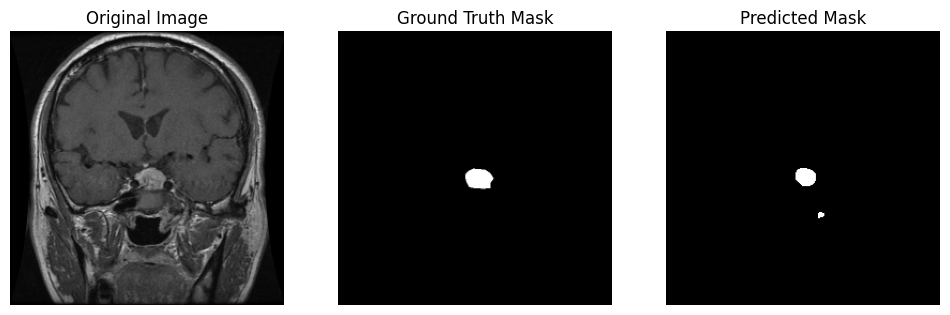

 65%|██████▌   | 13/20 [00:10<00:02,  2.54it/s]

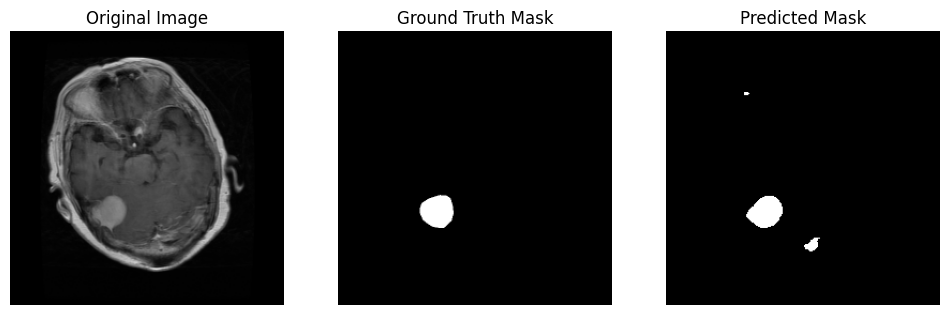

 70%|███████   | 14/20 [00:11<00:02,  2.64it/s]

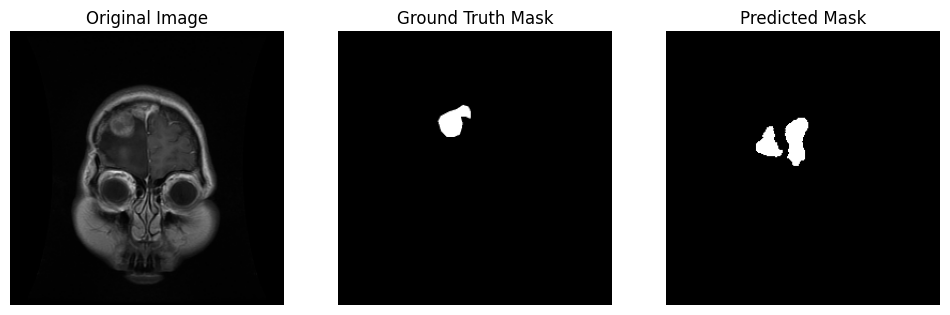

 75%|███████▌  | 15/20 [00:11<00:01,  2.72it/s]

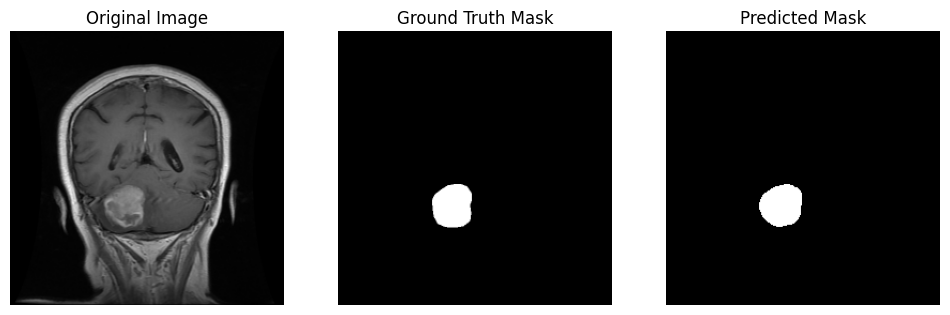

 80%|████████  | 16/20 [00:11<00:01,  2.77it/s]

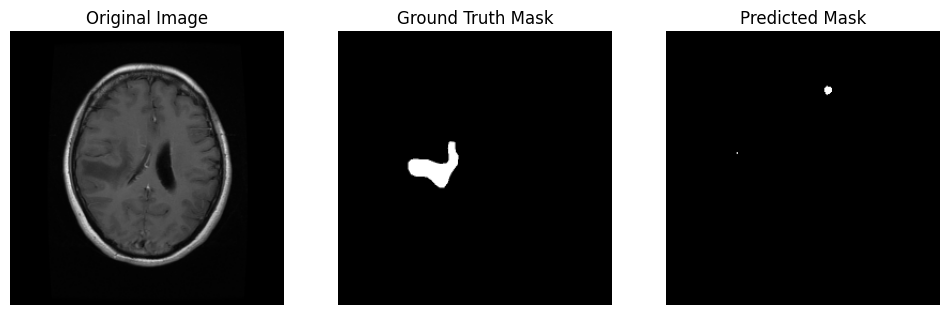

 85%|████████▌ | 17/20 [00:12<00:01,  2.82it/s]

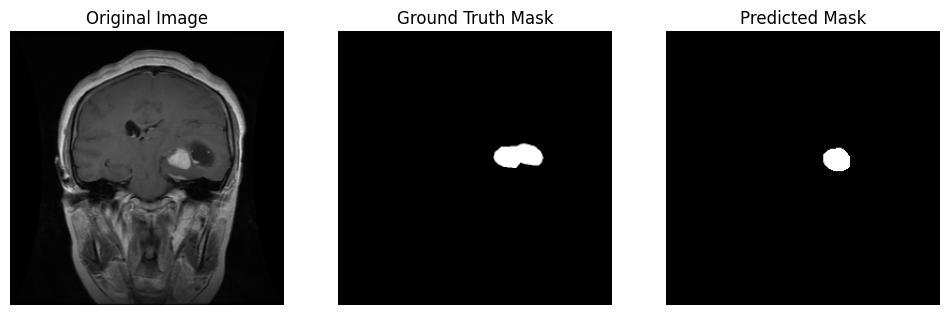

 90%|█████████ | 18/20 [00:12<00:00,  2.85it/s]

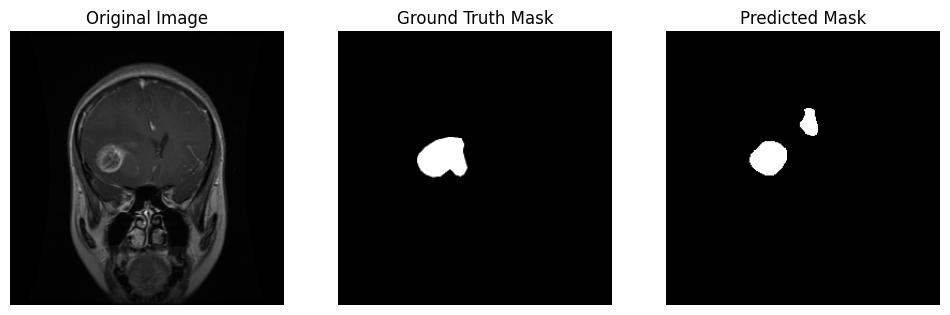

 95%|█████████▌| 19/20 [00:12<00:00,  2.86it/s]

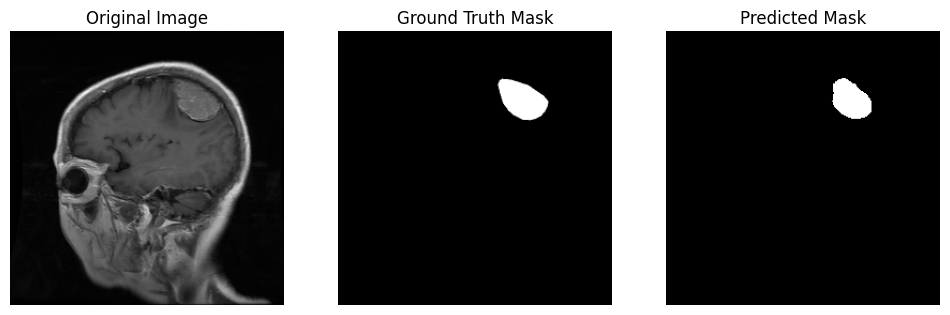

100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

Metrics saved to score.csv


In [19]:
import cv2
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Create a list to store the scores
scores = []

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred = (y_pred > 0.5).astype(np.uint8)
    y_true = (y_true > 0.5).astype(np.uint8)
    
    f1 = f1_score(y_true, y_pred, average='binary')
    iou = jaccard_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    
    return f1, iou, precision, recall

# Select 20 random images for prediction
random_indices = random.sample(range(len(test_x)), 20)
test_x_sampled = [test_x[i] for i in random_indices]
test_y_sampled = [test_y[i] for i in random_indices]

""" Prediction """
for x, y in tqdm(zip(test_x_sampled, test_y_sampled), total=len(test_x_sampled)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    x_input = image / 255.0
    
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(x_input, patch_shape, cf["patch_size"])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    patches = patches.astype(np.float32)
    patches = np.expand_dims(patches, axis=0)

    """ Read Mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    """ Prediction """
    pred = model.predict(patches, verbose=0)[0]
    pred = (pred > 0.5).astype(np.uint8)  # Convert probability to binary mask
    
    """ Calculate Metrics """
    f1, iou, precision, recall = calculate_metrics(mask, pred)
    scores.append([name, f1, iou, precision, recall])
    
    """ Save final mask """
    mask_vis = np.concatenate([mask, mask, mask], axis=-1) * 255
    pred_vis = np.concatenate([pred, pred, pred], axis=-1) * 255
    line = np.ones((cf["image_size"], 10, 3)) * 255
    cat_images = np.concatenate([image, line, mask_vis, line, pred_vis], axis=1)
    save_image_path = os.path.join("results", name)
    cv2.imwrite(save_image_path, cat_images)
    
    """ Show Images """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

""" Save scores to CSV """
df_scores = pd.DataFrame(scores, columns=["Image Name", "F1 Score", "Jaccard Score", "Precision", "Recall"])
df_scores.to_csv("files/score.csv", index=False)

print("Metrics saved to score.csv")


In [20]:
scores = pd.read_csv("/kaggle/working/files/score.csv")
scores

,Image Name,F1 Score,Jaccard Score,Precision,Recall
0,3001.png,0.279692,0.162582,0.900783,0.165547
1,1879.png,0.563444,0.392219,0.625839,0.512363
2,981.png,0.000000,0.000000,0.000000,0.000000
3,1344.png,0.914197,0.841954,0.879880,0.951299
4,2986.png,0.432113,0.275602,0.734940,0.306020
5,1826.png,0.871336,0.772007,0.817130,0.933245
6,855.png,0.858150,0.751544,0.933504,0.794054
7,2343.png,0.571122,0.399700,0.982780,0.402519
8,1590.png,0.831373,0.711409,0.805063,0.859459
9,1837.png,0.892385,0.805682,0.935356,0.853189
